# Neutralization curves for RBD MAP paper

## Experiments in this notebook:

2020-08-03 validation neutralization of 2165, 2832, 2479, and 2082 against WT and mutant pseudovirus

### Import modules for anlaysis

In [1]:
import math
import os

import dmslogo

import numpy as np

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import pandas as pd
from pandas.api.types import CategoricalDtype

from plotnine import *

import yaml

/fh/fast/bloom_j/computational_notebooks/agreaney/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/dmslogo/logo.py:40: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  matplotlib.font_manager.findSystemFonts(_FONT_PATH)))


Versions of key software:

In [2]:
print(f"Using neutcurve version {neutcurve.__version__}")

Using neutcurve version 0.4.2


### Set options for pandas

Make output directory if needed

In [3]:
os.makedirs('./results/', exist_ok=True)

### Define color palettes:
Some are from [PNWColors](https://github.com/jakelawlor/PNWColors).

In [4]:
# colorblind-friendly palette with grey:
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# PNWColors palettes
anemone = ["#999999", '#b0986c', '#dcbe9b', '#fae8da', '#efddcf', '#72e1e1', '#11c2b5', '#009474']
starfish = ["#999999", '#24492e', '#015b58', '#2c6184', '#59629b', "#89689d", "#ba7999", "#e69b99"]
cascades = ["#999999", "#2d4030", "#516823", "#dec000", "#e2e260", "#677e8e", "#88a2b9"]
sailboat = ["#999999", "#6e7cb9", "#7bbcd5", "#d0e2af", "#f5db99", "#e89c81", "#d2848d"]

### Import mutant neutralization validation data and reshape into an acceptable [format](https://jbloomlab.github.io/neutcurve/curvefits_example.html#preparing-the-data) for `neutcurve`

In [5]:
datafile = './data/200804_validate-neuts.csv'
data = (pd.read_csv(datafile)
        .melt(id_vars=['genotype', 'antibody', 'replicate'], 
              value_vars=['4000', '1000', '250', '62.5', '15.625', '3.90625', '0.9765625', '0.244140625'], 
              var_name='concentration', 
              value_name='frac_infectivity')
        .assign(frac_neutralized=lambda x: 1-x['frac_infectivity'], 
                concentration=lambda x: x['concentration'].astype(float)
               )
       )
data.head()

,genotype,antibody,replicate,concentration,frac_infectivity,frac_neutralized
0,wildtype,COV2-2165,1,4000.0,0.000046,0.999954
1,wildtype,COV2-2165,2,4000.0,0.000014,0.999986
2,wildtype,COV2-2832,1,4000.0,0.000004,0.999996
3,wildtype,COV2-2832,2,4000.0,0.000001,0.999999
4,wildtype,COV2-2479,1,4000.0,0.000099,0.999901


There are 7 genotypes for the 3 competing antibodies (2165, 2832, 2479), and 3 unique (not including wildtype) genotypes for 2082 only. 

I will use the `sailboat` palette for the 3 competing antibodies and part of the `cascades` palette for 2082. 

In [6]:
genotypes = list(data['genotype'].unique())
colors = sailboat[:7] + [cascades[5]] + [cascades[3]] + [cascades [1]]
markers = ['o', '^', 's', 'D', 'v', '<', '>', 'p', 'P', 'x']
color_marker_tuples = [(colors[i], markers[i]) for i in range(len(colors))]

virus_color_dictionary = res = dict(zip(genotypes, color_marker_tuples)) 

In [7]:
fits = neutcurve.CurveFits(
                        data,
                        fracinf_col='frac_infectivity',
                        serum_col='antibody',
                        virus_col='genotype',
                        fixbottom=0,
                        fixtop=1,
                        infectivity_or_neutralized='infectivity',
                        )

fits.fitParams().head()

/fh/fast/bloom_j/computational_notebooks/agreaney/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/neutcurve/hillcurve.py:689: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m)**s)


,serum,virus,replicate,nreplicates,ic50,ic50_bound,ic50_str,midpoint,slope,top,bottom
0,COV2-2165,wildtype,average,2,19.191707,interpolated,19.2,1.919171e+01,0.882654,1,0
1,COV2-2165,N487R,average,2,255.340417,interpolated,255,2.553404e+02,1.053435,1,0
2,COV2-2165,D420R,average,2,4000.000000,lower,>4e+03,1.287935e+06,0.205891,1,0
3,COV2-2165,F486A,average,2,23.532299,interpolated,23.5,2.353230e+01,1.381550,1,0
4,COV2-2165,A475V,average,2,10.021219,interpolated,10,1.002122e+01,0.992575,1,0


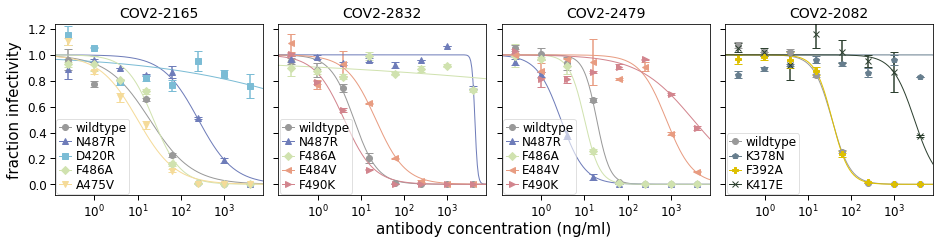

In [8]:
_ = fits.plotSera(
            xlabel='antibody concentration (ng/ml)',
            #ncol=3,
            ylabel='fraction infectivity',
            heightscale=1.2,
            widthscale=1.05,
            virus_to_color_marker=virus_color_dictionary,
            attempt_shared_legend=False,
            )

plotfile = PdfPages('./results/200803_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

We will probably want to report the data as log2 fold-change IC50 relative to wildtype (as we will do for the CR3022 binding data).

First, get the fit parameters for each curve. Extract the IC50s, and also determine if the midpoint is an upper / lower bound given the concentration ranges used, or if it is an interpolated value:

In [9]:
fitparams = (
    fits.fitParams()
    .rename(columns={'serum': 'antibody', 'virus': 'genotype'})
    # get columns of interest
    [['antibody', 'genotype', 'ic50', 'ic50_bound']] 
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

fitparams

,antibody,genotype,ic50,ic50_bound,ic50_is_bound
0,COV2-2165,wildtype,19.191707,interpolated,False
1,COV2-2165,N487R,255.340417,interpolated,False
2,COV2-2165,D420R,4000.000000,lower,True
3,COV2-2165,F486A,23.532299,interpolated,False
4,COV2-2165,A475V,10.021219,interpolated,False
5,COV2-2832,wildtype,6.923332,interpolated,False
6,COV2-2832,N487R,4000.000000,lower,True
7,COV2-2832,F486A,4000.000000,lower,True
8,COV2-2832,E484V,22.173671,interpolated,False
9,COV2-2832,F490K,4.107117,interpolated,False


In [10]:
foldchange = (
    fitparams
    .query('genotype != "wildtype"')
    .rename(columns={'genotype': 'mutant'})
    .merge(fitparams.query('genotype == "wildtype"')
                    [['antibody', 'ic50']]
                    .rename(columns={'ic50': 'wildtype_ic50'}),
           on=['antibody'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],
            log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2))
    )

foldchange

,antibody,mutant,ic50,ic50_bound,ic50_is_bound,wildtype_ic50,fold_change,log2_fold_change
0,COV2-2165,N487R,255.340417,interpolated,False,19.191707,13.304727,3.733867
1,COV2-2165,D420R,4000.000000,lower,True,19.191707,208.423358,7.703373
2,COV2-2165,F486A,23.532299,interpolated,False,19.191707,1.226170,0.294159
3,COV2-2165,A475V,10.021219,interpolated,False,19.191707,0.522164,-0.937425
4,COV2-2832,N487R,4000.000000,lower,True,6.923332,577.756481,9.174318
5,COV2-2832,F486A,4000.000000,lower,True,6.923332,577.756481,9.174318
6,COV2-2832,E484V,22.173671,interpolated,False,6.923332,3.202746,1.679309
7,COV2-2832,F490K,4.107117,interpolated,False,6.923332,0.593228,-0.753341
8,COV2-2479,N487R,2.866277,interpolated,False,19.340577,0.148200,-2.754381
9,COV2-2479,F486A,10.097365,interpolated,False,19.340577,0.522082,-0.937652


Saving to results/fold_change_IC50.pdf


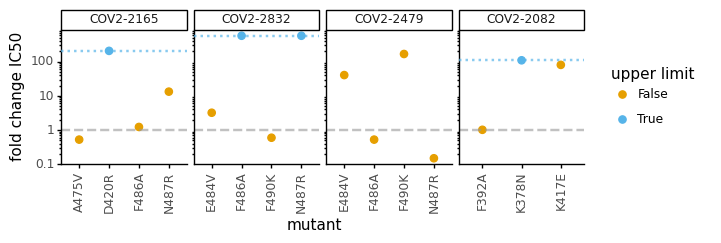

In [11]:
# plot in this order
antibody_order = ["COV2-2165", "COV2-2832", "COV2-2479", "COV2-2082"]
cat_type = CategoricalDtype(antibody_order,  ordered=True)
assert set(foldchange['antibody']).issubset(set(antibody_order))
foldchange['antibody'] = foldchange['antibody'].astype(cat_type)

# upper bound of measured fold change
upper_bound = (
    foldchange
    .query('ic50_bound == "lower"')
    [['antibody', 'fold_change']]
    .drop_duplicates()
    )
assert len(upper_bound) == upper_bound['antibody'].nunique()

p = (ggplot(foldchange
            .assign(ic50_is_bound=lambda x: x['ic50_is_bound'],
                    )
            ) +
     aes('mutant', 'fold_change', color='ic50_is_bound') +
     geom_point(size=2.5) +
     scale_y_log10(name='fold change IC50') +
     facet_grid('~antibody', scales='free') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.75 * foldchange['mutant'].nunique(), 1.75),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(data=upper_bound,
                mapping=aes(yintercept='fold_change'),
                color=CBPALETTE[2],
                alpha=0.7,
                size=1,
                linetype='dotted',
                ) +
     scale_color_manual(values=CBPALETTE[1:],
                        name='upper limit')
     )

_ = p.draw()

plotfile = 'results/fold_change_IC50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

### Now plot luciferase titers for the various pseudoviruses. 

In [12]:
titerfile = './data/200803_titers.csv'
titers = (pd.read_csv(titerfile)
          .melt(id_vars=['uL_virus', 'replicate'], 
                value_vars=['wildtype', 'K378N', 'V382Y', 'F392A', 'K417E', 'N487R', 'E484V', 'F490K', 'F490L'],
                var_name='genotype',
                value_name='RLU')
          .assign(logRLU=lambda x: np.log(x['RLU']) / np.log(10),
                  RLUperuL=lambda x: x['RLU'] / x['uL_virus'],
                  logRLUperuL=lambda x: np.log(x['RLU'] / x['uL_virus']) / np.log(10),
                 )
       )

titer_cat = CategoricalDtype(categories=['wildtype', 'K378N', 'V382Y', 'F392A', 'K417E', 'N487R', 'E484V', 'F490K', 'F490L'],
                            ordered=True)

titers['genotype']=titers['genotype'].astype(titer_cat)

titers.head()

,uL_virus,replicate,genotype,RLU,logRLU,RLUperuL,logRLUperuL
0,0.260417,1,wildtype,117430.0,5.069779,450931.199423,5.654110
1,1.041667,1,wildtype,326828.0,5.514319,313754.879900,5.496590
2,4.166667,1,wildtype,1325710.0,6.122449,318170.399975,5.502660
3,16.666667,1,wildtype,5971470.0,6.776081,358288.199928,5.554233
4,16.666667,2,wildtype,5966568.0,6.775725,357994.079928,5.553876


Saving to results/RLU-vs-uL_log.pdf


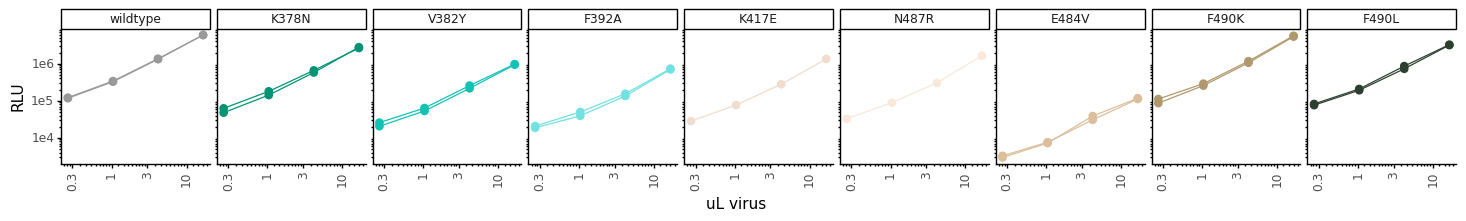

In [13]:
p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLU', color='genotype', group='replicate') +
     geom_point(size=2.5) +
     geom_line() +
     facet_grid('~genotype') +
     scale_y_log10(name='RLU') +
     scale_x_log10(name='uL virus') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * titers['uL_virus'].nunique() * titers['genotype'].nunique(), 
                        1.75),
           ) +
     scale_color_manual(values=anemone[0:1]+anemone[:0:-1]+cascades[1:], guide=False)
     )

_ = p.draw()

plotfile = 'results/RLU-vs-uL_log.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to results/logRLUperuL-vs-uL_log.pdf


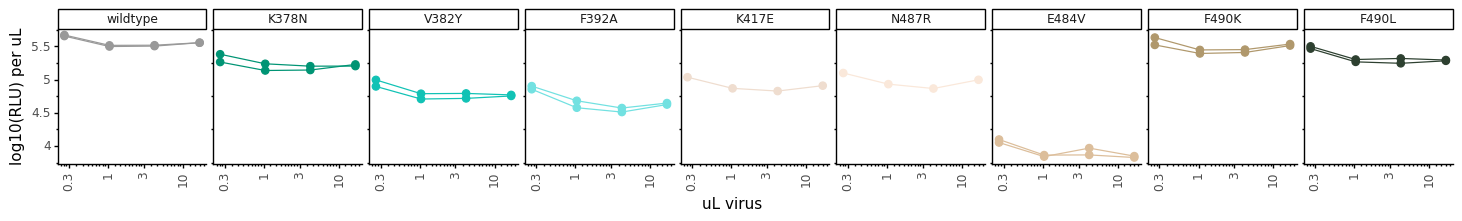

In [14]:
p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'logRLUperuL', color='genotype', group='replicate') +
     geom_point(size=2.5) +
     geom_line() +
     facet_grid('~genotype') +
     ylab('log10(RLU) per uL') +
     scale_x_log10(name='uL virus') +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * titers['uL_virus'].nunique() * titers['genotype'].nunique(), 
                        1.75),
           ) +
     scale_color_manual(values=anemone[0:1]+anemone[:0:-1]+cascades[1:], guide=False)
     )

_ = p.draw()

plotfile = 'results/logRLUperuL-vs-uL_log.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

From this, we can see that the lowest point seems to be systematically higher for every single virus. 
Thus, I will exclude this point, and calculate an average logRLUperuL for every virus.
Then look at RLU relative to wildtype. 

In [15]:
average_titers = (titers
                  .dropna() # missing values for some replicates
                  .query('uL_virus > 0.3') # drop lowest concentration of virus
                  .groupby(['genotype', 'replicate'])
                  .agg(mean_logRLUperuL=pd.NamedAgg(column='logRLUperuL', aggfunc=np.mean), 
                       mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean)
                      )
                  .reset_index()
                 )

average_titers

,genotype,replicate,mean_logRLUperuL,mean_RLUperuL
0,wildtype,1,5.517828,330071.159934
1,wildtype,2,5.528029,337612.399933
2,K378N,1,5.168508,148089.479970
3,K378N,2,5.213188,163496.379967
4,V382Y,1,4.725096,53156.699989
5,V382Y,2,4.781930,60539.679988
6,F392A,1,4.569650,37332.159992
7,F392A,2,4.632180,43104.899991
8,K417E,1,4.866979,73831.379985
9,K417E,2,NaN,NaN


In [16]:
titers_foldchange = (
    average_titers
    #.query('genotype != "wildtype"')
    .rename(columns={'genotype': 'mutant'})
    .merge(average_titers.query('genotype == "wildtype"')
           [['replicate', 'mean_logRLUperuL']]
                    .rename(columns={'mean_logRLUperuL': 'wildtype_logRLU'}),
           on=['replicate'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change_log=lambda x: x['mean_logRLUperuL'] / x['wildtype_logRLU'],
            log2_fold_change_log=lambda x: np.log(x['fold_change_log']) / np.log(2))
    .merge(average_titers.query('genotype == "wildtype"')
           [['replicate', 'mean_RLUperuL']]
                    .rename(columns={'mean_RLUperuL': 'wildtype_RLU'}),
           on=['replicate'],
           how='left',
           validate='many_to_one',
          )
    .assign(fold_change=lambda x: x['mean_RLUperuL'] / x['wildtype_RLU'],
            log10_fold_change=lambda x: np.log(x['fold_change']) / np.log(10))
    )

titers_foldchange

,mutant,replicate,mean_logRLUperuL,mean_RLUperuL,wildtype_logRLU,fold_change_log,log2_fold_change_log,wildtype_RLU,fold_change,log10_fold_change
0,wildtype,1,5.517828,330071.159934,5.517828,1.000000,0.000000,330071.159934,1.000000,0.000000
1,wildtype,2,5.528029,337612.399933,5.528029,1.000000,0.000000,337612.399933,1.000000,0.000000
2,K378N,1,5.168508,148089.479970,5.517828,0.936693,-0.094352,330071.159934,0.448659,-0.348083
3,K378N,2,5.213188,163496.379967,5.528029,0.943046,-0.084599,337612.399933,0.484272,-0.314910
4,V382Y,1,4.725096,53156.699989,5.517828,0.856333,-0.223757,330071.159934,0.161046,-0.793050
5,V382Y,2,4.781930,60539.679988,5.528029,0.865033,-0.209172,337612.399933,0.179317,-0.746378
6,F392A,1,4.569650,37332.159992,5.517828,0.828161,-0.272017,330071.159934,0.113103,-0.946524
7,F392A,2,4.632180,43104.899991,5.528029,0.837944,-0.255074,337612.399933,0.127676,-0.893892
8,K417E,1,4.866979,73831.379985,5.517828,0.882046,-0.181074,330071.159934,0.223683,-0.650367
9,K417E,2,NaN,NaN,5.528029,NaN,NaN,337612.399933,NaN,NaN


/fh/fast/bloom_j/computational_notebooks/agreaney/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


Saving to results/foldchange_RLU.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


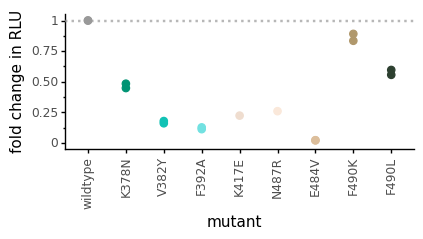

In [17]:
p = (ggplot(titers_foldchange
            ) +
     aes('mutant', 'fold_change', color='mutant') +
     geom_point(size=2.5) +
     ylab("fold change in RLU") +
     expand_limits(y=0) +
     geom_hline(yintercept=1, linetype='dotted', size=1,
                alpha=0.7, color=CBPALETTE[0]) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.5 * average_titers['genotype'].nunique(), 
                        1.75),
           ) +
     scale_color_manual(values=anemone[0:1]+anemone[:0:-1]+cascades[1:], guide=False)
     )

_ = p.draw()

plotfile = 'results/foldchange_RLU.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

/fh/fast/bloom_j/computational_notebooks/agreaney/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_jitter : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


Saving to results/log10_foldchange_RLU.pdf


/fh/fast/bloom_j/computational_notebooks/agreaney/2020/SARS-CoV-2-RBD_MAP/env/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_jitter : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


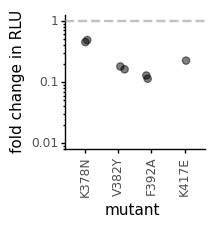

In [18]:
CR3022_muts = ['K378N', 'V382Y', 'F392A', 'K417E'] # also removed wildtype, since absent from EC50 fold change plots

p = (ggplot(titers_foldchange.query('mutant in @CR3022_muts')
            ) +
     aes('mutant', 'fold_change') +
     geom_jitter(size=2.5, height=0, width=0.2, alpha=0.5) +
     scale_y_log10(name="fold change in RLU") +
     expand_limits(y=0.01) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.45 * len(set(CR3022_muts)), 
                        1.75),
           )
     )

_ = p.draw()

plotfile = 'results/log10_foldchange_RLU.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

## Make paper figure
First, we need to read in the escape fractions from the main pipeline:

In [19]:
basedir = '../../'

with open(os.path.join(basedir, 'config.yaml')) as f:
    config = yaml.safe_load(f)
    
escape_fracs_file = os.path.join(basedir, config['escape_fracs'])
print(f"Reading escape fracs from {escape_fracs_file}")
escape_fracs = pd.read_csv(escape_fracs_file)

escape_fracs

Reading escape fracs from ../../results/escape_scores/escape_fracs.csv


,selection,library,condition,site,label_site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_epistasis_model,mut_escape_frac_single_mut,site_total_escape_frac_epistasis_model,site_total_escape_frac_single_mut,site_avg_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,nlibs
0,2B04_400,average,2B04_400,1,331,N,A,E,331,0.001158,0.000603,0.05429,0.06513,0.002857,0.003428,2
1,2B04_400,average,2B04_400,1,331,N,C,E,331,0.001114,0.002096,0.05429,0.06513,0.002857,0.003428,2
2,2B04_400,average,2B04_400,1,331,N,D,E,331,0.001114,0.001018,0.05429,0.06513,0.002857,0.003428,2
3,2B04_400,average,2B04_400,1,331,N,E,E,331,0.001160,0.001079,0.05429,0.06513,0.002857,0.003428,2
4,2B04_400,average,2B04_400,1,331,N,F,E,331,0.002955,0.001223,0.05429,0.06513,0.002857,0.003428,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144076,mAb-2E06_400,lib2,mAb-2E06_400_lib2,201,531,T,R,E,531,0.001116,0.000452,0.01410,0.01150,0.000742,0.000605,1
144077,mAb-2E06_400,lib2,mAb-2E06_400_lib2,201,531,T,S,E,531,0.001117,0.000408,0.01410,0.01150,0.000742,0.000605,1
144078,mAb-2E06_400,lib2,mAb-2E06_400_lib2,201,531,T,V,E,531,0.000217,0.000756,0.01410,0.01150,0.000742,0.000605,1
144079,mAb-2E06_400,lib2,mAb-2E06_400_lib2,201,531,T,W,E,531,0.000411,0.000572,0.01410,0.01150,0.000742,0.000605,1


Add the CR3022 EC50 to the fold changes and upper bounds:

In [20]:
foldchange['antibody'].unique()

[COV2-2165, COV2-2832, COV2-2479, COV2-2082]
Categories (4, object): [COV2-2165 < COV2-2832 < COV2-2479 < COV2-2082]

In [21]:
foldchange_cr3022 = (pd.read_csv('../mammalian_RBD_display_for_CR3022/results/foldchange.csv')
                     .replace('CR3022', 'rCR3022') #replace CR3022 with rCR3022
                    )

display(foldchange_cr3022)

foldchange = (
    foldchange
    .query('antibody != "CR3022"')
    [['antibody', 'mutant', 'fold_change']]
    .assign(quantity='IC50')
    .append(foldchange_cr3022[['antibody', 'mutant', 'fold_change']].assign(quantity='EC50'))
    )

upper_bound_cr3022 = pd.read_csv('../mammalian_RBD_display_for_CR3022/results/upper_bound.csv')
upper_bound = (upper_bound.query('antibody != "CR3022"').append(upper_bound_cr3022))

,antibody,date,mutant,midpoint,midpoint_is_bound,wildtype_midpoint,fold_change,log2_fold_change
0,rCR3022,2020-07-17,K378N,10000.000000,True,14.205197,100.000000,9.459365
1,rCR3022,2020-07-17,F392A,29.320781,False,14.205197,2.064088,1.045505
2,rCR3022,2020-07-29,K417E,6.797398,False,8.253859,0.823542,-0.280086
3,rCR3022,2020-07-29,V382Y,17.477845,False,8.253859,2.117536,1.082387


Rename CR3022 to rCR3022

In [22]:
foldchange = foldchange.replace('CR3022', 'rCR3022')

Map the names of antibodies we are using to samples shown in paper:

In [23]:
with open(os.path.join(basedir, config['escape_profiles_config'])) as f:
    escape_profiles_config = yaml.safe_load(f)
    
selection_to_antibody = escape_profiles_config['MAP_paper_antibodies']['conditions']

antibodies = foldchange['antibody'].unique()

assert set(antibodies).issubset(set(selection_to_antibody.values()))

escape_fracs = (
    escape_fracs
    .assign(antibody=lambda x: x['selection'].map(selection_to_antibody))
    )

assert set(antibodies).issubset(escape_fracs['antibody'])

Make the plot:

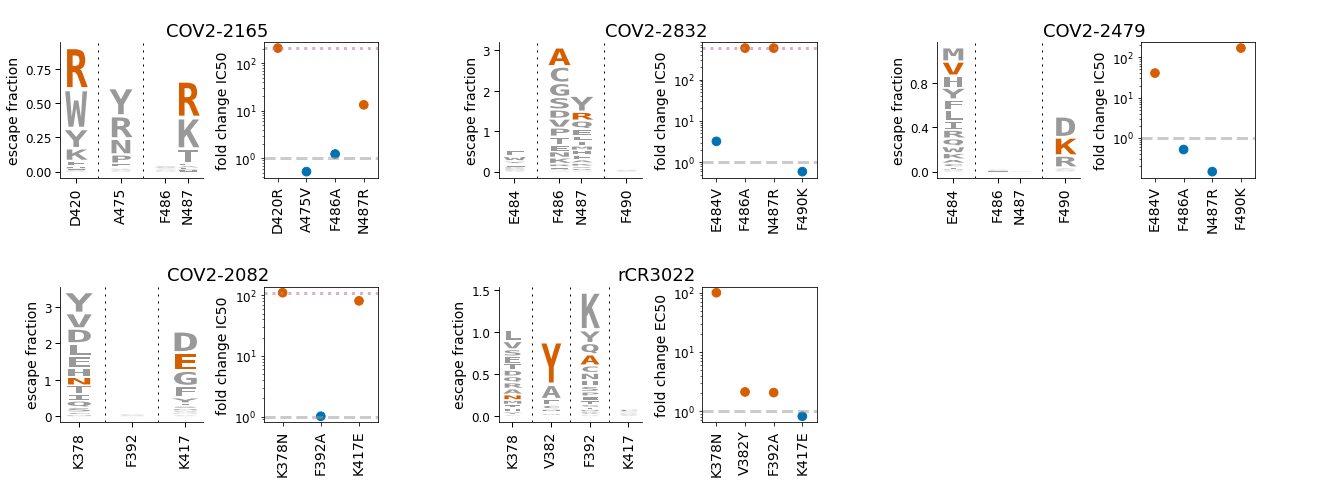

Saving to results/validation_figure_all_antibodies.pdf


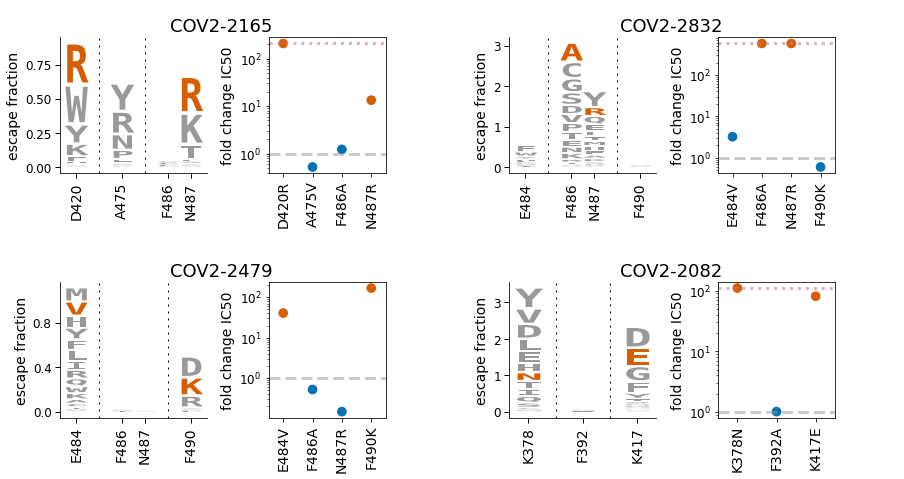

Saving to results/validation_figure_neut_antibodies.pdf


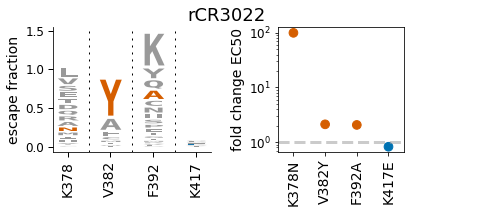

Saving to results/validation_figure_rCR3022.pdf


In [24]:
mut_metric = config['mut_metric']

# define a general function, then apply it to different antibody sets
def make_plot(antibodies, maxcols, plotfile, subplots_adjust_kwargs):
    """Make plot for list of antibodies with indicated maximum number of columns."""

    ncols = min(maxcols, len(antibodies))
    nrows = math.ceil(len(antibodies) / ncols)
    fig, axes = plt.subplots(nrows=nrows,
                             ncols=3 * ncols,
                             figsize=(7.5 * ncols, 3.5 * nrows if nrows > 1 else 3),
                             gridspec_kw={
                                 'width_ratios': [1, 0.8, 0.001] * ncols,  # 3rd dummy plot for spacing
                                 }
                             )
    # improve padding between plots and margins
    plt.subplots_adjust(wspace=0.7, hspace=0.8, **subplots_adjust_kwargs)

    for i, antibody in enumerate(antibodies):

        antibody_foldchange = (
            foldchange
            .query('antibody == @antibody')
            .assign(site=lambda x: x['mutant'].map(lambda s: int(s[1: -1])),
                    wildtype=lambda x: x['mutant'].str[0],
                    mutation=lambda x: x['mutant'].str[-1],
                    )
            .sort_values('site')
            )
        sites = sorted(antibody_foldchange['site'].unique())
        mutants_escape = set(antibody_foldchange.query('fold_change > 10')['mutant']).union(
                            set(antibody_foldchange.query('fold_change > 2 and antibody == "rCR3022"')['mutant']))
        mutants_noescape = set(antibody_foldchange['mutant']) - mutants_escape
        logodata = (
            escape_fracs
            .assign(site=lambda x: x['label_site'],
                    wt_site=lambda x: x['wildtype'] + x['site'].astype(str),
                    mutant=lambda x: x['wt_site'] + x['mutation'],
                    color=lambda x: x['mutant'].map(lambda m: CBPALETTE[6] if m in mutants_escape
                                                              else CBPALETTE[5] if m in mutants_noescape
                                                              else CBPALETTE[0])
                    )
            .query('antibody == @antibody')
            .query('library == "average"')
            .query('site in @sites')
            )
    
        logo_ax = axes.ravel()[3 * i]
        _ = dmslogo.draw_logo(
                data=logodata,
                x_col='site',
                letter_col='mutation',
                letter_height_col=mut_metric,
                ylabel='escape fraction',
                xtick_col='wt_site',
                xlabel='',
                color_col='color',
                ax=logo_ax,
                )
        plt.setp(logo_ax.get_xticklabels(), size=14)
        logo_ax.set_ylabel('escape fraction', size=14)
        logo_ax.set_title(antibody, size=18, x=1.1)
    
        quantity = antibody_foldchange['quantity'].values[0]
        npoints = len(antibody_foldchange.drop_duplicates())
        foldchange_ax = axes.ravel()[3 * i + 1]
        antibody_foldchange.plot(
                    x='mutant',
                    y='fold_change',
                    kind='scatter',
                    logy=True,
                    ax=foldchange_ax,
                    color=[CBPALETTE[6] if mutant in mutants_escape else CBPALETTE[5]
                           for mutant in antibody_foldchange['mutant'].tolist()],
                    s=75,
                    )
        foldchange_ax.set_xlabel(None)
        foldchange_ax.set_ylabel(f"fold change {quantity}", size=14)
        plt.setp(foldchange_ax.get_xticklabels(), rotation=90, size=14)
        plt.setp(foldchange_ax.get_yticklabels(), size=12)
        foldchange_ax.set_xlim(-0.5, npoints - 1 + 0.5)
        foldchange_ax.axhline(y=1, color=CBPALETTE[0], alpha=0.5, ls='--', lw=3)
        if antibody in upper_bound['antibody'].values:
            foldchange_ax.axhline(y=upper_bound.set_index('antibody')['fold_change'].to_dict()[antibody],
                                  alpha=0.6, ls=':', lw=3, color=CBPALETTE[7])
        
        padding_ax = axes.ravel()[3 * i + 2]
        padding_ax.axis('off')

    for ax in axes.ravel()[3 * len(antibodies): ]:
        ax.axis('off')
    
    display(fig)
    print(f"Saving to {plotfile}")
    fig.savefig(plotfile)
    plt.close(fig)
    
# apply function to different sets of antibodies
for antibody_list, maxcols, plotfile, subplots_adjust_kwargs in [
        (antibodies, 3, 'results/validation_figure_all_antibodies.pdf', {}),
        ([a for a in antibodies if a != 'rCR3022'], 2, 'results/validation_figure_neut_antibodies.pdf', {}),
        (['rCR3022'], 2, 'results/validation_figure_rCR3022.pdf', {'bottom': 0.3}),
        ]:
    make_plot(antibody_list, maxcols, plotfile, subplots_adjust_kwargs)